In [2]:
!pip install fastai

     -------------------------------------- 233.1/233.1 kB 4.7 MB/s eta 0:00:00
     --------------------------------------- 12.2/12.2 MB 23.4 MB/s eta 0:00:00
     ---------------------------------------- 67.6/67.6 kB ? eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 25.2 MB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 22.7 MB/s eta 0:00:00
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
     ---------------------------------------- 94.7/94.7 kB ? eta 0:00:00
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached spacy_loggers-1.0.4-py3-none-any.whl (11 kB)
  Using cached pathy-0.10.1-py3-none-any.whl (48 kB)
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
     ---------------------------------------- 1.5/1.5 MB 23.5 MB/s eta 0:00:00
     ------------------------------------- 480.9/480.9 kB 31.4 MB/s eta 0:00:00
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached wasabi-1.1.1-py3-non

In [1]:
from fastai.vision.all import *

In [2]:
#The dataset can be downloaded and decompressed with this line of code:
path = untar_data(URLs.PETS)

In [3]:
#It will only do this download once,
#and return the location of the decompressed archive. We can check what is inside with the .ls() method.
path.ls()

(#3) [Path('C:/Users/55449/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/55449/.fastai/data/oxford-iiit-pet/images'),Path('C:/Users/55449/.fastai/data/oxford-iiit-pet/models')]

In [4]:
#get_image_files is a fastai function that helps us grab all the image files (recursively) in one folder.
files = get_image_files(path/"images")
len(files)

7390

# Cats vs dogs
To label our data for the cats vs dogs problem, 

we need to know which filenames are of dog pictures and which ones are of cat pictures.

There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs:

In [5]:
files[0],files[6]

(Path('C:/Users/55449/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 Path('C:/Users/55449/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'))

In [6]:
#We can then define an easy label function:
def label_func(f):
    return f[0].isupper() #ou .islower() para rotular cachorros como true

To get our data ready for a model, we need to put it in a DataLoaders object. Here we have a function that labels using the file names, so we will use ImageDataLoaders.from_name_func. There are other factory methods of ImageDataLoaders that could be more suitable for your problem, so make sure to check them all in vision.data.

In [7]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

We have passed to this function the directory we’re working in, the files we grabbed, our label_func and one last piece as item_tfms: this is a Transform applied on all items of our dataset that will resize each image to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn’t pass this, we would get an error later as it would be impossible to batch the items together.

We can then check if everything looks okay with the show_batch method (True is for cat, False is for dog):

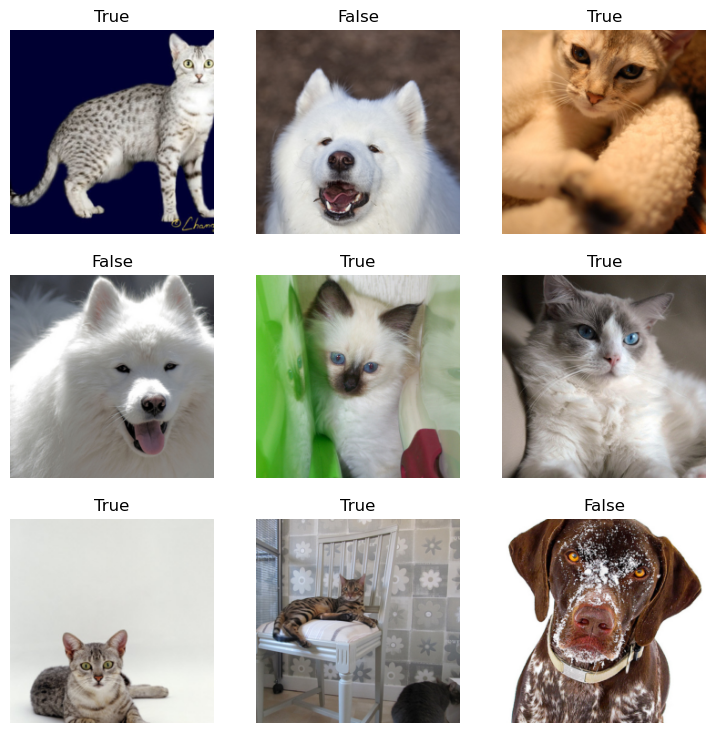

In [8]:
dls.show_batch()

Then we can create a Learner, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [9]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

C:\Users\55449\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\55449\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.144556,0.022765,0.008119,19:04


epoch,train_loss,valid_loss,error_rate,time
0,0.056425,0.033291,0.011502,29:12


In [13]:
learn.export('C:/Users/55449/Documents/GitHub/Arquivos/imagens/modelo.pkl')

The first line downloaded a model called ResNet34, pretrained on ImageNet, and adapted it to our specific problem. It then fine tuned that model and in a relatively short time, we get a model with an error rate of well under 1%… amazing!

If you want to make a prediction on a new image, you can use learn.predict:

In [14]:
learn.predict(files[0])

('True', tensor(1), tensor([9.4432e-05, 9.9991e-01]))

The predict method returns three things: the decoded prediction (here False for dog), the index of the predicted class and the tensor of probabilities of all classes in the order of their indexed labels(in this case, the model is quite confident about the being that of a dog). This method accepts a filename, a PIL image or a tensor directly in this case. We can also have a look at some predictions with the show_results method:

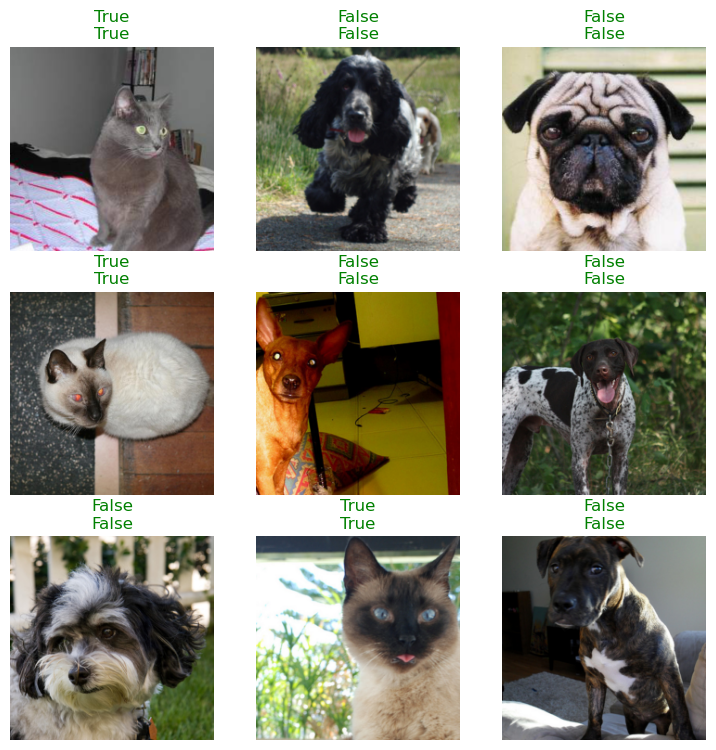

In [29]:
learn.show_results()

# Classifying breeds
To label our data with the breed name, we will use a regular expression to extract it from the filename. Looking back at a filename, we have:

In [32]:
files[0].name

'Abyssinian_1.jpg'

so the class is everything before the last _ followed by some digits. A regular expression that will catch the name is thus:

In [33]:
pat = r'^(.*)_\d+.jpg'

Since it’s pretty common to use regular expressions to label the data (often, labels are hidden in the file names), there is a factory method to do just that:

In [34]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

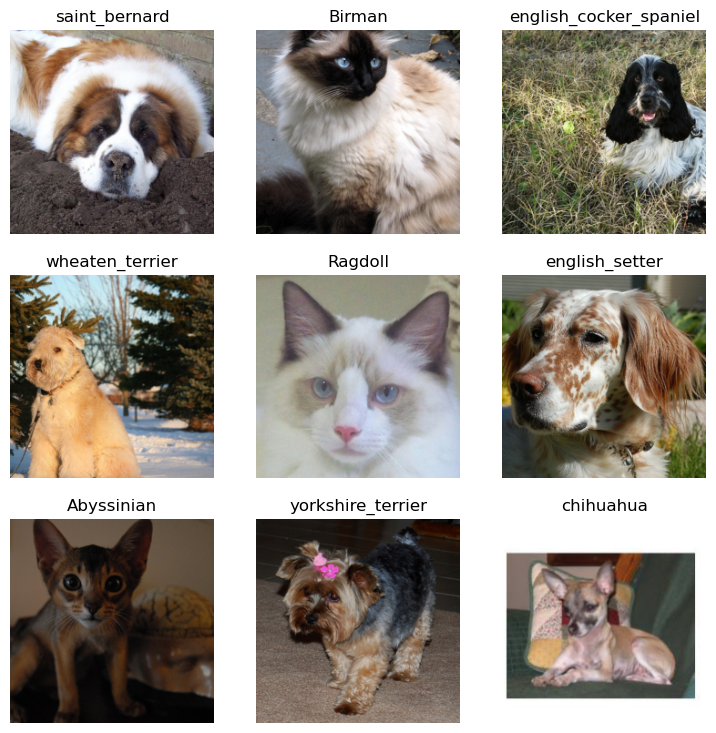

In [35]:
dls.show_batch()

Since classifying the exact breed of cats or dogs amongst 37 different breeds is a harder problem, we will slightly change the definition of our DataLoaders to use data augmentation:

In [36]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

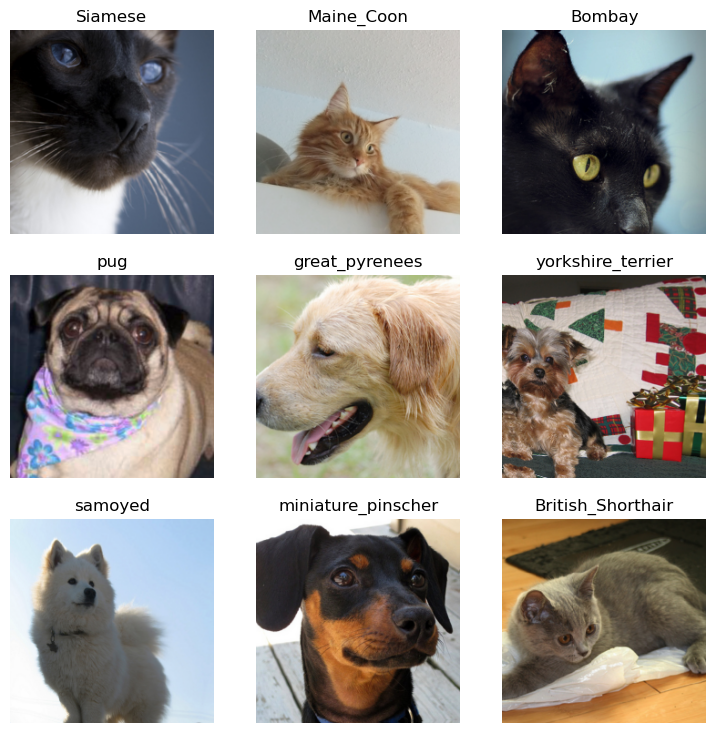

In [37]:
dls.show_batch()

We can then create our Learner exactly as before and train our model.

In [38]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(valley=0.0012022644514217973)

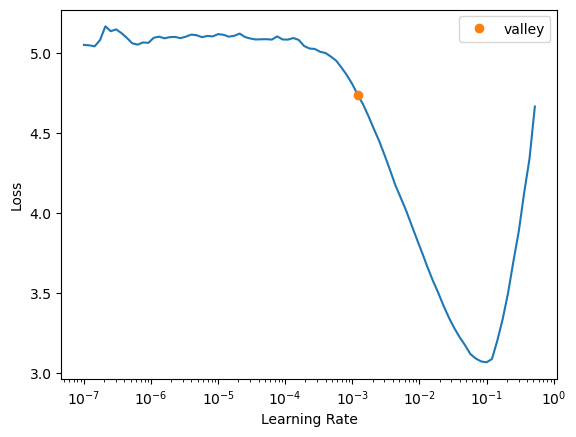

In [39]:
learn.lr_find()

It plots the graph of the learning rate finder and gives us two suggestions (minimum divided by 10 and steepest gradient). Let’s use 3e-3 here. We will also do a bit more epochs:

In [40]:
learn.fine_tune(2, 3e-3)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 